# Pyroomacoustics Demo

### dependencies:  pyroomacoustics, pysoundfile, samplerate

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import fftconvolve
import IPython
import pyroomacoustics as pra
import soundfile

plt.rcParams['font.size'] = 20
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15

%matplotlib inline

import librosa
import librosa.display
import samplerate

import IPython.display as ipd

from scipy import signal

import pyroomacoustics as pra
from pyroomacoustics.doa import circ_dist

import pandas as pd

%load_ext autoreload
%autoreload 2
from doa_lib import *

## Read file and show it in spectogram 

In [6]:
file_name = '../recordings/180910_142834.wav'
signal_times=[[69.9, 70.6], [110.8, 111.7], [155.8, 156.7], [285.7, 286.3]]
algo_name = 'MUSIC'
hot_sig = 0

ang_error_per_length = dict()
for length in np.array([0.3, 0.5, 1., 1.5, 2.]):
    ang_error = dict()

    for y_loc in range(2,9):
        room_dim = [10000, 20, 10000]
        r_source=np.c_[[5005, y_loc, 5000]]
        r_rec=np.c_[
            [5000, 5-length/2., 5000],  # mic 1
            [5000, 5+length/2., 5000],  # mic 2
            ]

        rx_center = r_rec.mean(axis=1, keepdims=True)
        v = r_source-rx_center
        base_vec = np.c_[[1,0,0]]
        c = np.dot(v.T, base_vec)/np.linalg.norm(base_vec)/np.linalg.norm(v) # -> cosine of the angle
        angle = np.arccos(np.clip(c, -1, 1)) # if you really want the angle
        azimuth = [np.mod(2*np.pi+np.sign(v[1])[0]*angle[0,0],2*np.pi)]

        # reshape into 1d numpy array
        r_source = r_source[:,0]

        ang_error[y_loc] = []

        for times in signal_times:
            data, fs = read_sound(file_name, time=times)

            rec_signal = sim_room(data, fs, absorption=0.8, r_source=r_source, r_rec=r_rec, room_dim=room_dim)

            for noise_ind in range(4): 
                rec_signal_noised = add_noise(rec_signal, SNR=10, noise_id=(noise_ind,noise_ind+1),
                                              noise_location_doc='silence_180910_142834.txt')

                if hot_sig:
                    clim = (-70,-20)
                    spect(data/np.sqrt(np.sum(data**2)), fs, figsize=[20,5])
                    plt.colorbar()
                    plt.clim(clim)

                    spect(rec_signal_noised[0,:], fs, figsize=[20,5])
                    plt.colorbar()
                    plt.clim(clim)

                    spect(rec_signal_noised[1,:], fs, figsize=[20,5])
                    plt.colorbar()
                    plt.clim(clim)
                    hot_sig = 0

                nfft = 1024*8
                overlap_ratio = 1
                X = np.array([produce_spect_for_music(channel_sig, nfft=nfft, overlap_ratio=overlap_ratio, fft_type='stft')
                              for channel_sig in rec_signal_noised])

                doa = locate_source(X[:, :, :], r_rec, fs, nfft, algo_name, freq_range = [300., 800.])
    #             plot_doa(doa, azimuth, algo_name)

                angle_grid = doa.grid.azimuth*180/np.pi
                doa_values = doa.grid.values

                ind_select = (angle_grid<90) | (angle_grid>270)

                select_angle = angle_grid[ind_select][np.argmax(doa_values[ind_select])]

                error_angle = np.abs(select_angle-azimuth[0]*180/np.pi)

                ang_error[y_loc].append(error_angle)
    
    ang_error_per_length[length] = ang_error

    #             raise(Exception('stop'))

In [4]:
np.concatenate((error_list.reshape(-1,1), error_list_fliped.reshape(-1,1)), axis=1)

NameError: name 'error_list' is not defined

In [34]:
error_dict = dict()
for s_depth in ang_error.keys():
    error_list = np.array(ang_error[s_depth])
    error_list_fliped = 360-error_list
    error_list = np.min(np.concatenate((error_list.reshape(-1,1), error_list_fliped.reshape(-1,1)), axis=1), axis=1)
    
    error_dict[180*np.arctan((s_depth-5)/5.)/np.pi] = error_list.mean()
    print(s_depth, error_list.mean())

2 19.463756532073575
3 9.400704743175893
4 13.345033762989885
5 4.5
6 21.595033762989896
7 13.0
8 14.731878266036752


In [35]:
error_df_0_5m = pd.DataFrame.from_dict(error_dict, orient='index').reset_index()
error_df_0_5m.columns = ['angle', 'error']
error_df_0_5m.head()

,angle,error
0,-30.963757,19.463757
1,-21.801409,9.400705
2,-11.309932,13.345034
3,0.000000,4.500000
4,11.309932,21.595034


In [17]:
error_df_1m = pd.DataFrame.from_dict(error_dict, orient='index').reset_index()
error_df_1m.columns = ['angle', 'error']
error_df_1m.head()

,angle,error
0,-30.963757,4.481878
1,-21.801409,4.500000
2,-11.309932,9.595034
3,0.000000,1.500000
4,11.309932,7.500000


In [29]:
error_df_1_5m = pd.DataFrame.from_dict(error_dict, orient='index').reset_index()
error_df_1_5m.columns = ['angle', 'error']
error_df_1_5m.head()

,angle,error
0,-30.963757,11.000000
1,-21.801409,19.000000
2,-11.309932,9.345034
3,0.000000,2.000000
4,11.309932,10.250000


In [25]:
error_df_2m = pd.DataFrame.from_dict(error_dict, orient='index').reset_index()
error_df_2m.columns = ['angle', 'error']
error_df_2m.head()

,angle,error
0,-30.963757,13.981878
1,-21.801409,10.150705
2,-11.309932,24.250000
3,0.000000,0.500000
4,11.309932,23.000000


## SNR 10, 0.6 attenuation, 10m ocean, Blue - 0.3m , Orange - 0.5m , Green - 1m , Red - 1.5m, Purple - 2m 

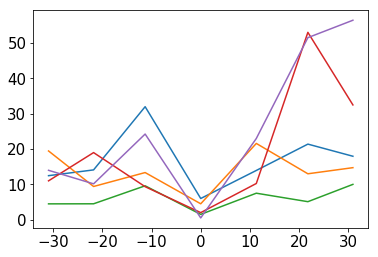

In [5]:
for length in ang_error_per_length.keys():
    error_dict = dict()
    for s_depth in ang_error.keys():
        error_list = np.array(ang_error_per_length[length][s_depth])
        error_list_fliped = 360-error_list
        error_list = np.min(np.concatenate((error_list.reshape(-1,1), error_list_fliped.reshape(-1,1)), axis=1), axis=1)

        error_dict[180*np.arctan((s_depth-5)/5.)/np.pi] = error_list.mean()
    
    error_df = pd.DataFrame.from_dict(error_dict, orient='index').reset_index()
    plt.plot(error_df.iloc[:,0].values, error_df.iloc[:,1].values)
    
plt.show()

## SNR 10, 0.9 attenuation, 10m ocean, Blue - 0.5m , Orange - 1m , Green - 1.5m , Red - 2m 

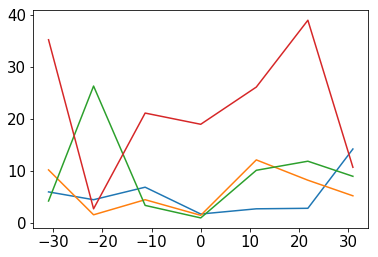

In [11]:
for length in ang_error_per_length.keys():
    error_dict = dict()
    for s_depth in ang_error.keys():
        error_list = np.array(ang_error_per_length[length][s_depth])
        error_list_fliped = 360-error_list
        error_list = np.min(np.concatenate((error_list.reshape(-1,1), error_list_fliped.reshape(-1,1)), axis=1), axis=1)

        error_dict[180*np.arctan((s_depth-5)/5.)/np.pi] = error_list.mean()
    
    error_df = pd.DataFrame.from_dict(error_dict, orient='index').reset_index()
    plt.plot(error_df.iloc[:,0].values, error_df.iloc[:,1].values)
    
plt.show()

## SNR 10, 0.7 attenuation, 20m ocean, Blue - 0.5m , Orange - 1m , Green - 1.5m , Red - 2m 

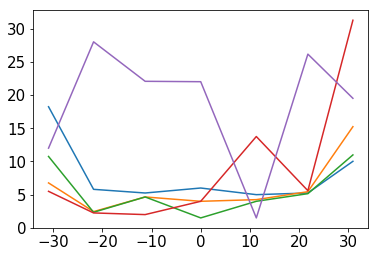

In [7]:
for length in ang_error_per_length.keys():
    error_dict = dict()
    for s_depth in ang_error.keys():
        error_list = np.array(ang_error_per_length[length][s_depth])
        error_list_fliped = 360-error_list
        error_list = np.min(np.concatenate((error_list.reshape(-1,1), error_list_fliped.reshape(-1,1)), axis=1), axis=1)

        error_dict[180*np.arctan((s_depth-5)/5.)/np.pi] = error_list.mean()
    
    error_df = pd.DataFrame.from_dict(error_dict, orient='index').reset_index()
    plt.plot(error_df.iloc[:,0].values, error_df.iloc[:,1].values)
    
plt.show()

In [35]:
angle_grid = doa.grid.azimuth*180/np.pi
doa_values = doa.grid.values
            
ind_select = (angle_grid<90) | (angle_grid>270)


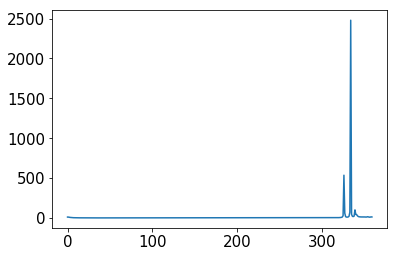

In [37]:
plt.plot(doa.grid.azimuth[ind_select]*180/np.pi,doa.grid.values[ind_select])
plt.show()

NameError: name 'rec_signal' is not defined

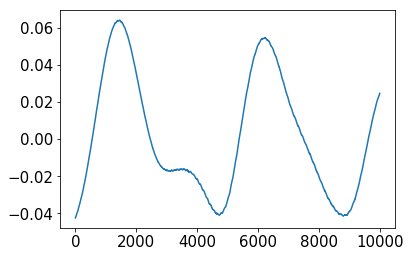

In [15]:
extent = 10000

plt.plot(data[:extent])
plt.plot(rec_signal[0,:extent])
plt.plot(rec_signal[1,:extent])
plt.plot(0*rec_signal[1,:extent])
plt.show()